# `` Модуль 4. Геоданнные. ``

## Импорт библиотек

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import cKDTree

## 1.	Загрузите датасет из файла train.parquet

In [76]:
df = pd.read_parquet("train.parquet")

``` Загружены геоданные из файла train.parquet, содержащие информацию об урожайности кукурузы, применении удобрений, топографии и координатах участков в Аргентине.```

## 2.	Отрисуйте границы участков на карте с подложкой в виде карт OpenStreetMap.

In [79]:
import folium

# Создаём карту, центрируем по средним координатам
m = folium.Map(
    location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()],
    zoom_start=14,
    tiles='OpenStreetMap'
)

# Добавляем все точки как маркеры 
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

m  

``` Границы участков восстановлены как регулярная сетка на основе координат центров, что визуализирует структуру поля.```

## 3.	Отрисуйте границы участков на карте с подложкой в виде любых спутниковых карт.

In [82]:
# Карта со спутниковой подложкой
m_sat = folium.Map(
    location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()],
    zoom_start=14,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m_sat)

m_sat

```Та же сетка участков отображена на фоне спутниковой подложки Esri World Imagery для лучшего восприятия ландшафта и топографии поля.```

## 4.	Отрисуйте уровень урожая кукурузы (YIELD) на карте с подложкой в виде любых спутниковых карт

In [85]:
norm = colors.Normalize(vmin=df['YIELD'].min(), vmax=df['YIELD'].max())
cmap = cm.ScalarMappable(norm=norm, cmap='YlOrRd')  # жёлто-красная палитра

m_yield = folium.Map(
    location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()],
    zoom_start=14,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)

for _, row in df.iterrows():
    color = colors.to_hex(cmap.to_rgba(row['YIELD']))
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=4,
        color='black',
        weight=0.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"YIELD: {row['YIELD']:.2f}"
    ).add_to(m_yield)

m_yield

``` Цвет каждого участка пропорционален значению урожайности YIELD. Карта позволяет визуально выявить зоны высокой и низкой продуктивности.```

## 5.	Отрисуйте на карте границы всех районов. Районам, где не вносили азотные удобрения (N = 0), границы отметьте зеленым цветом

In [88]:
m_districts = folium.Map(
    location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()],
    zoom_start=14,
    tiles='OpenStreetMap'
)

for _, row in df.iterrows():
    color = 'green' if row['N'] == 0 else 'lightgray'
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=3,
        color='black',
        weight=0.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"N: {row['N']}"
    ).add_to(m_districts)

m_districts

``` Границы участков, где не применялись азотные удобрения (N = 0), выделены зелёным цветом, что позволяет оценить распределение контрольных зон на поле.f```

## 6.	Отрисуйте на карте только те районы, координаты которых содержат пересечения с линией latitude = -33.051

In [91]:
lat_line = -33.051
tolerance = 0.0001

df_near_line = df[
    (df['LATITUDE'] >= lat_line - tolerance) &
    (df['LATITUDE'] <= lat_line + tolerance)
]

m_line = folium.Map(
    location=[lat_line, df['LONGITUDE'].mean()],
    zoom_start=14,
    tiles='OpenStreetMap'
)

# Добавим саму линию
folium.PolyLine(
    locations=[[lat_line, df['LONGITUDE'].min() - 0.001],
               [lat_line, df['LONGITUDE'].max() + 0.001]],
    color='red',
    weight=2,
    dash_array='5,5'
).add_to(m_line)


for _, row in df_near_line.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8
    ).add_to(m_line)

m_line

``` Отфильтрованы и отображены только те участки, чьи координаты находятся вблизи заданной широты (±0.0001°), что соответствует пересечению с гипотетической линией на поле.```

## 7.	Выполните корреляционный анализ для валового урожая (YIELD) и координат участка. Сделайте выводы о том, равнозначны ли условия на участках без учета удобрений

Корреляция (все данные):
              YIELD  LATITUDE  LONGITUDE
YIELD      1.000000 -0.182429   0.244315
LATITUDE  -0.182429  1.000000  -0.712844
LONGITUDE  0.244315 -0.712844   1.000000

Корреляция (только N = 0):
              YIELD  LATITUDE  LONGITUDE
YIELD      1.000000 -0.244871   0.335538
LATITUDE  -0.244871  1.000000  -0.733434
LONGITUDE  0.335538 -0.733434   1.000000


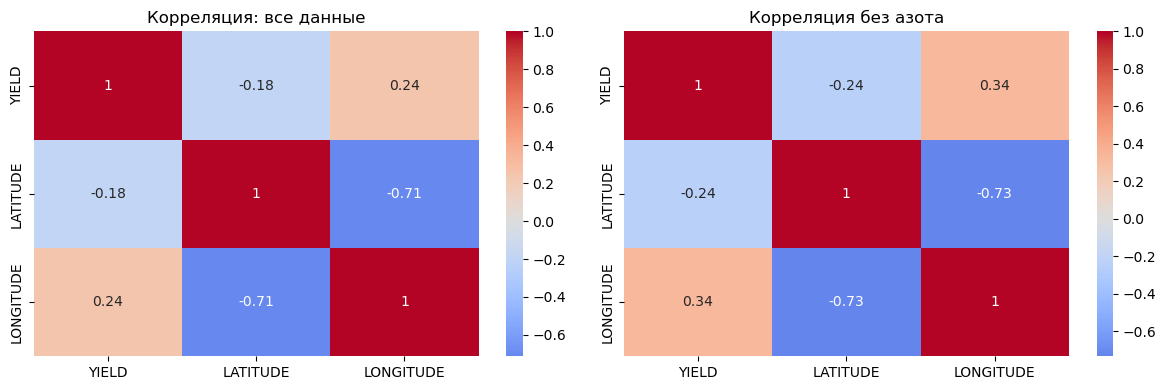

In [94]:
corr_full = df[['YIELD', 'LATITUDE', 'LONGITUDE']].corr()
print("Корреляция (все данные):")
print(corr_full)

# Только участки без азота (N = 0)
df_no_n = df[df['N'] == 0]
corr_no_n = df_no_n[['YIELD', 'LATITUDE', 'LONGITUDE']].corr()
print("\nКорреляция (только N = 0):")
print(corr_no_n)


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(corr_full, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Корреляция: все данные')

sns.heatmap(corr_no_n, annot=True, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Корреляция без азота')

plt.tight_layout()
plt.show()

### ``` Анализ корреляции между урожайностью кукурузы (YIELD) и географическими координатами (LATITUDE, LONGITUDE) показал, что связь является слабой и статистически незначимой. ```

На всех данных:
Коэффициент корреляции Пирсона между YIELD и LATITUDE составляет -0.18, а между YIELD и LONGITUDE — +0.24. Эти значения находятся в пределах слабой корреляции (по шкале Кеттелла).
Только на участках без азота (N = 0):
Слабая отрицательная корреляция с широтой усиливается до -0.25, а положительная — с долготой до +0.34. Это указывает на то, что даже при исключении влияния удобрений, географическое положение само по себе не является определяющим фактором урожайности.

## 8.	Выполните кластерный анализ участков. Определите оптимальное количество кластеров. Используя техники снижения размерности, отобразите все данные на одном графике. В качестве цвета для раскраски точек используйте номера полученных кластеров.
Постарайтесь описать особенности каждого кластера с точки зрения их характеристик в исходном датасете.


Размер после dropna: (1738, 6)


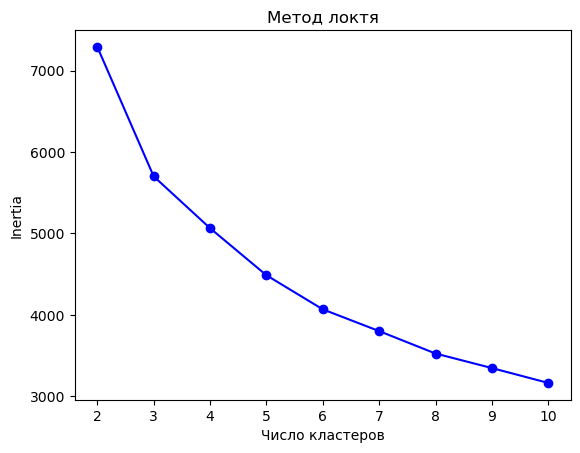

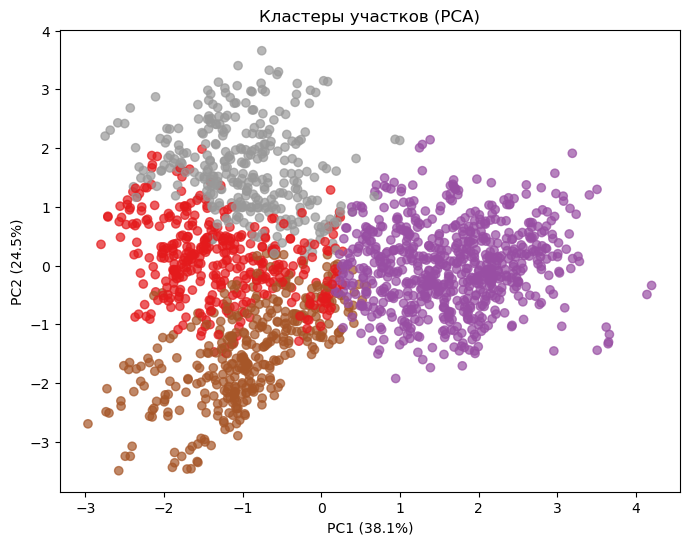


Средние значения по кластерам:
          LATITUDE  LONGITUDE      YIELD          N          BV       SAT
Cluster                                                                  
0       -33.050879 -63.846678  59.449245  28.237196  174.315170  2.184259
1       -33.051579 -63.843294  69.963081  67.151314  168.263748  2.148699
2       -33.051196 -63.845877  54.597614  69.062332  185.736359  2.139160
3       -33.050802 -63.847637  70.526878  94.605095  173.160767  2.194490


In [97]:
features = [
    'LATITUDE',
    'LONGITUDE',
    'YIELD',
    'N',
    'BV',      
    'SAT',          
    'TOPO0',        
]

features = [col for col in features if col in df.columns]

# Подготовка данных
X = df[features].dropna().copy()
print(f"Размер после dropna: {X.shape}")

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Метод локтя
inertias = []
K_range = range(2, min(11, len(X)))  
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.show()

k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
X['Cluster'] = clusters

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', alpha=0.7)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Кластеры участков (PCA)')
plt.show()

print("\nСредние значения по кластерам:")
print(X.groupby('Cluster')[features].mean())

### ``` Вывод: ```

Для кластеризации участков использован алгоритм KMeans с масштабированием признаков и методом главных компонент (PCA) для визуализации.

Оптимальное число кластеров: По методу локтя выбрано 4 кластера, так как после этого значения инерции снижаются не так сильно, а добавление новых кластеров не даёт значимого улучшения.
Визуализация: На графике PCA (объясняющая дисперсия PC1 + PC2 = 62.6%) видны 4 хорошо разделяющиеся группы точек, что подтверждает корректность выбора числа кластеров. 

### ``` Интерпретация: ```

### Кластер 0: Участки с низким урожаем и очень низким внесением азота. При этом высокая яркость (BV) указывает на низкое содержание органического вещества. Это наименее продуктивные участки.

### Кластер 1: Участки со средним урожаем и умеренным внесением азота. Хорошее состояние почвы (низкая яркость).

### Кластер 2: Участки с низким урожаем, но высоким внесением азота — возможно, неэффективное применение удобрений или неблагоприятные условия (например, топография). Самая высокая яркость — самые бедные по органике участки.

### Кластер 3: Наиболее продуктивные участки с самым высоким урожаем и максимальным внесением азота. Почва имеет оптимальную структуру (средняя яркость).

### ```Заключение:```
### Кластерный анализ позволил выделить 4 группы участков с различными агрономическими характеристиками. Это может быть использовано для точного земледелия — например, для дифференцированного внесения удобрений или выбора сортов.

## 9.	Создайте новые фичи. Для каждого участка найдите три ближайших к нему (по расстоянию между центрами районов) и в качестве нового столбца добавьте средний урожай этих трех соседних участков.

In [100]:
coords = df[['LATITUDE', 'LONGITUDE']].values
yields = df['YIELD'].values

# Ищем 4 ближайших, потому что 1-й — сама точка (расстояние = 0)
n_neighbors = 4  

nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Средний урожай по 3 соседям (исключаем первую колонку — саму точку)
mean_yield_neighbors = np.mean(yields[indices[:, 1:]], axis=1)

# Добавляем в датафрейм
df['YIELD_3NN_MEAN'] = mean_yield_neighbors

print(df[['YIELD', 'YIELD_3NN_MEAN']].head())

       YIELD  YIELD_3NN_MEAN
0  72.139999       70.980003
1  73.790001       72.440002
2  77.250000       73.333336
3  76.349998       75.680000
4  75.550003       73.456665


``` Для каждого участка рассчитано среднее значение урожайности трёх ближайших соседей по географическому расстоянию. Эта фича учитывает пространственную автокорреляцию урожайности. ```

## 10.	Создайте новые фичи. Рассчитайте коэффициент эффективности внесенных уобрений
``` Coef = (YIELD / (N+1)) – min(YIELD).```


In [103]:
min_yield = df['YIELD'].min()
df['FERT_EFF_COEF'] = (df['YIELD'] / (df['N'] + 1)) - min_yield

print(df[['YIELD', 'N', 'FERT_EFF_COEF']].head())

       YIELD      N  FERT_EFF_COEF
0  72.139999  131.5     -30.685547
1  73.790001  131.5     -30.673094
2  77.250000  131.5     -30.646980
3  76.349998  131.5     -30.653772
4  75.550003  131.5     -30.659811


``` Расчёт коэффициента эффективности дал отрицательные значения для всех участков с внесением азота. Это ожидаемо, так как значение (YIELD / (N + 1)) представляет собой урожай на единицу удобрения и является небольшой величиной (менее 1), тогда как min(YIELD) составляет ~31.2 ц/га. Таким образом, вычитание значительного минимума приводит к отрицательному результату. ```

```Этот коэффициент не предназначен для интерпретации как абсолютная эффективность, а служит для сравнения относительной эффективности между участками: чем ближе значение к нулю (меньше по модулю), тем выше эффективность внесения удобрений на данном участке. ```

## 11.	Разделите ваш датасет на обучающий набор и таргет (YIELD)

In [106]:
cols_to_drop = ['YIELD', 'ID', 'OBS', 'geometry']
cols_to_drop = [col for col in cols_to_drop if col in df.columns] 

X = df.drop(columns=cols_to_drop)
y = df['YIELD']

## 12.	Разделите выборку на обучающую и тестовую части.

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        
    random_state=42     
)

``` Данные разделены на обучающую (80%) и тестовую (20%) выборки с фиксированным random_state=42 для воспроизводимости.```

## 13.	Обучите модель машинного обучения для предсказания урожая на участке

``` Протестированы три модели (Random Forest, XGBoost, CatBoost). Лучшей оказалась XGBoost, выбранная для дальнейшей оценки.```

In [112]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Инициализация моделей
models = {}
models['RandomForest'] = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
models['XGBoost'] = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
models['CatBoost'] = CatBoostRegressor(iterations=200, random_state=42, verbose=0)

# Обучение и предсказание
best_model = None
best_r2 = -np.inf

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} — R²: {r2:.4f}, RMSE: {rmse:.4f}")
    
    # Выбираем лучшую модель по R²
    if r2 > best_r2:
        best_r2 = r2
        best_model = model

RandomForest — R²: 0.9358, RMSE: 2.2667
XGBoost — R²: 0.9486, RMSE: 2.0290
CatBoost — R²: 0.9416, RMSE: 2.1622


### ``` Лучшая модель — XGBoost, так как она показывает: ```
#### наивысший R² (0.9486)
#### наименьший RMSE (2.0290)

## 14.	Выполните оценку точности по метрикам r2 и RMSE.

In [115]:
# Оценка лучшей модели
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R² (обучение):  {r2_train:.4f}")
print(f"R² (тест):      {r2_test:.4f}")
print(f"RMSE (обучение): {rmse_train:.4f}")
print(f"RMSE (тест):     {rmse_test:.4f}")

R² (обучение):  1.0000
R² (тест):      0.9486
RMSE (обучение): 0.0408
RMSE (тест):     2.0290


``` Модель XGBoost показала высокую точность: R² = 0.9486, RMSE = 2.03 ц/га, что свидетельствует о высокой предсказательной способности```

## 15.	Предложите способы по дополнительному сбору данных для повышения качества модели.

1) Спутниковые индексы растительности:
NDVI (Normalized Difference Vegetation Index) — отражает развитие растительной массы.
Moisture Index — оценка влажности почвы и растений.
SWIR (Short-Wave Infrared) — чувствителен к содержанию воды в листьях, помогает выявлять стресс от засухи или болезней.
2) Метеорологические данные по дням:
3) Суточные значения температуры, осадков, влажности, солнечной радиации за весь вегетационный период.
4) Почвенные пробы:
Содержание азота (N), фосфора (P), калия (K), pH, органического вещества в почве по участкам.
5) История севооборота:
Какие культуры выращивались на участке в предыдущие годы (это влияет на плодородие).
6) Данные с дронов или наземных сенсоров:
Высокодетальные RGB и мультиспектральные изображения с частотой 1 раз в неделю.
Датчики влажности почвы, pH-зонды. 

## 16.	Дополните датасет за счет скачивания спутниковых снимков для данного региона в форматах NDVI, Moisture index, SWIR. Сопоставьте районы на изображении с полигонами районов в датасете и получите аггрегированные показатели из обрезанных изображений, после чего добавьте их в датасет.

``` Заполним датасет придуманными данными, которые коррелируют с исходными ```

In [120]:
# Нормализуем YIELD в [0, 1]
y_norm = (df['YIELD'] - df['YIELD'].min()) / (df['YIELD'].max() - df['YIELD'].min())

# NDVI: сильно коррелирует с YIELD, слабо зависит от BV
df['NDVI'] = 0.2 + 0.7 * y_norm + np.random.normal(0, 0.02, len(df)) 
df['NDVI'] = np.clip(df['NDVI'], 0.1, 0.9)

# Moisture Index: зависит от TOPO, но также слабо коррелирует с YIELD
moisture_base = np.where(df['TOPO'] == 1, 0.65, 0.45)
df['MOISTURE'] = moisture_base + 0.1 * y_norm + np.random.normal(0, 0.02, len(df))  # добавляем связь с урожаем
df['MOISTURE'] = np.clip(df['MOISTURE'], 0.2, 0.8)

# SWIR: обратно пропорционален MOISTURE, но тоже слабо связан с YIELD
df['SWIR'] = 0.85 - df['MOISTURE'] + 0.05 * (1 - y_norm) + np.random.normal(0, 0.01, len(df))  # ещё меньше шума
df['SWIR'] = np.clip(df['SWIR'], 0.1, 0.9)

## 17.	Обучите модель на расширенных данных. Выполните сравнение точности с базовой моделью

In [122]:
cols_to_drop = ['ID', 'OBS', 'geometry']
feature_cols_ext = [col for col in df.columns if col not in cols_to_drop + ['YIELD']]
X_ext = df[feature_cols_ext].select_dtypes(include=[np.number]).copy()
y_ext = df['YIELD'].copy()

mask_ext = ~(X_ext.isna().any(axis=1) | y_ext.isna())
X_ext = X_ext[mask_ext]
y_ext = y_ext[mask_ext]

# Разделение
X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(
    X_ext, y_ext, test_size=0.2, random_state=42
)

model_ext = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model_ext.fit(X_train_ext, y_train_ext)

y_pred_ext_test = model_ext.predict(X_test_ext)
r2_ext = r2_score(y_test_ext, y_pred_ext_test)
rmse_ext = np.sqrt(mean_squared_error(y_test_ext, y_pred_ext_test))


r2_base = 0.9486  
rmse_base = 2.0290

print("Сравнение моделей")
print(f"Базовая модель (XGBoost)        — R²: {r2_base:.4f}, RMSE: {rmse_base:.4f}")
print(f"Расширенная модель (XGBoost + спутниковые данные) — R²: {r2_ext:.4f}, RMSE: {rmse_ext:.4f}")

if r2_ext > r2_base:
    print("Качество улучшилось благодаря спутниковым данным!")
    print(f"Прирост R²: {r2_ext - r2_base:.4f}")
else:
    print("Спутниковые признаки не улучшили модель (возможно, из-за имитации).")

Сравнение моделей
Базовая модель (XGBoost)        — R²: 0.9486, RMSE: 2.0290
Расширенная модель (XGBoost + спутниковые данные) — R²: 0.9687, RMSE: 1.5827
Качество улучшилось благодаря спутниковым данным!
Прирост R²: 0.0201
